In [1]:
import heeps
from heeps.util.img_processing import resize_cube
from heeps.util.freq_decomp import get_zernike, psd_spatial_zernike, psd_temporal
from copy import deepcopy
import os.path
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# Input parameters

In [2]:
nzer = 100
nimg = 720
npupil = 285
date = '20210601'
duration = 3600
samp_wv = 100 # wv sampling in ms
samp_scao = 300 # scao sampling in ms
step = int(samp_scao/samp_wv)
temporal_rms = 8814.11
rms_L = 100
rms_N = 1200
ncube_psd = 100 # number of frames for PSD
nzer_psd = 20 # number of Z modes for PSD
# rainbow map colors
colors = np.array([cm.rainbow(i) for i in np.linspace(0, 1, nzer_psd)])

In [3]:
dir_current = '/mnt/disk4tb/METIS/METIS_CBASIC_CUBES'
filename = 'cube_Cbasic_%s_%ss_%sms_0piston_meters_scao_only_%s.fits'
scao = os.path.join(dir_current, filename%('20201130', duration, samp_scao, npupil))
wv = os.path.join(dir_current, 'water_vapor', (filename%(date, duration, samp_wv, nimg))[:-5] + '_WV.fits')
pup = fits.getdata(os.path.join(dir_current, 'water_vapor/mask_Cbasic_20210601_720.fits'))
pup[pup < .5] = 0
# pup should NOT have NANs for prop_fit_zernikes

In [4]:
def plot_tpsd(y1, label1, y2, label2, title, z=[1,2,3,4,8,12,16,20]):
    x = np.arange(y1.shape[1])/duration
    plt.figure(figsize=(12,6))
    plt.grid(True), plt.grid(which='minor', linestyle=':')
    for ys, label, ls in zip([y1, y2], [label1, label2], ['-', ':']):
        for i, y in enumerate(ys):
            color = 'k' if i==0 else colors[i-1]
            if i+1 in z:
                plt.loglog(x, y, color=color, label='Z%s %s'%(i+1, label), linestyle=ls)
    plt.legend(ncol=2, fontsize='small')
    plt.xlim((1e-2, max(x)))
    plt.ylim((1e3, 1e11))
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Temporal PSD [nm^2/Hz]')
    plt.savefig('WV_temp_psd_Z%s_%s.png'%(nzer, title.replace(' ', '_')), dpi=300, transparent=True)

def get_zpols_roll(zpols, nLF, nHF):
    zpols_roll_name = wv[:-5] + '_zpols_%s_nLF_%s_nHF_%s.fits'%(nzer, nLF, nHF)
    try:
        zpols_roll = fits.getdata(zpols_roll_name)
        print('getdata ' + zpols_roll_name)
    except FileNotFoundError:
        print('writeto ' + zpols_roll_name)
        zpols_roll = deepcopy(zpols)
        for i in range(len(zpols_roll)):
            end = max(i, 1)
            start = max(i-nLF, 0)
            zpols_roll[i,1:3] = np.mean(zpols[start:end,1:3], 0)
            start = max(i-nHF, 0)
            zpols_roll[i,3:] = np.mean(zpols[start:end,3:], 0)
        fits.writeto(zpols_roll_name, np.float32(zpols_roll))

def get_zpols_integ(zpols, nLF, nHF, G):
    zpols_integ_name = wv[:-5] + '_zpols_%s_nLF_%s_nHF_%s_G_%s.fits'%(nzer, nLF, nHF, G)
    try:
        zpols_integ = fits.getdata(zpols_integ_name)
        print('getdata ' + zpols_integ_name)
    except FileNotFoundError:
        print('writeto ' + zpols_integ_name)
        zpols_integ = np.zeros(zpols.shape)
        # piston
        zpols_integ[:,0] = zpols[:,0]
        # tip-tilt
        m = range(1,3)
        freq = nLF
        for n in range(freq, len(zpols), freq):
            zpols_integ[n:n+freq,m] = zpols_integ[n-1,m] + G*np.mean(zpols[n-freq:n,m] - zpols_integ[n-1,m], 0)
        # higher modes
        m = range(3,nzer)
        freq = nHF
        for n in range(freq, len(zpols), freq):
            zpols_integ[n:n+freq,m] = zpols_integ[n-1,m] + G*np.mean(zpols[n-freq:n,m] - zpols_integ[n-1,m], 0)
        fits.writeto(zpols_integ_name, np.float32(zpols_integ))

def plot_integ(nframes, zmodes, scaling, yunits='nm', nLF=1, nHF=10):
    Z = zpols[:nframes,zmodes]
    #Z = np.array([Z[0]]*30)
    ts = np.arange(len(Z))*samp_wv/1e3
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
    a0 = axs[0]
    a1 = axs[1]
    for G in [.2, .4, .6, .8, 1]:
        zpols_integ_name = wv[:-5] + '_zpols_%s_nLF_%s_nHF_%s_G_%s.fits'%(nzer, nLF, nHF, G)
        X = fits.getdata(zpols_integ_name)[:nframes,zmodes]
        Y = Z - X
        a0.plot(ts, np.sqrt(np.sum(X**2,1))*scaling, label='G = %s'%G)
        a1.plot(ts, np.sqrt(np.sum(Y**2,1))*scaling, label='G = %s'%G)
    a0.set_title('correction')
    a0.set_ylabel('WFE (%s)'%yunits)
    a0.legend(loc='lower right'); a0.grid(True)
    a0.set_xlim((0, ts[-1]))
    a1.set_title('residual error')
    a1.set_xlabel('Duration (s)')
    a1.set_ylabel('WFE (%s)'%yunits)
    a1.legend(loc='upper right'); a1.grid(True)
    a1.set_xlim((0, ts[-1]));

# 1/ Water vapor with no correction
### Spatial PSD

getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100.fits
getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_spsd_20.fits


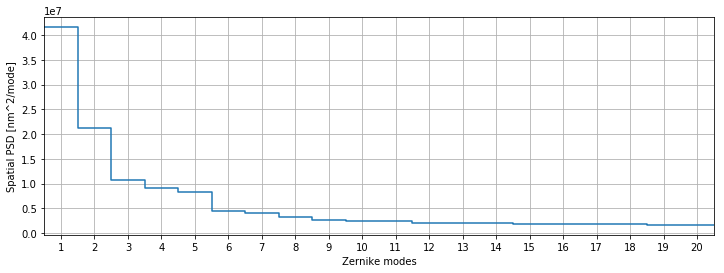

In [5]:
zpols = get_zernike(wv, pup, nzer)
spsd = psd_spatial_zernike(wv, pup, zpols, nzer_psd, ncube_psd)*1e9**2
plt.figure(figsize=(12,4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
x = np.arange(nzer_psd + 1) + .5
plt.plot(x, spsd, ls='steps')
plt.xlabel('Zernike modes')
plt.ylabel('Spatial PSD [nm^2/mode]')
plt.xlim((.5, nzer_psd + .5))
plt.xticks(np.arange(nzer_psd) + 1)
plt.savefig('WV_spat_psd_Z%s.png'%nzer_psd, dpi=300, transparent=True)

### One frame example

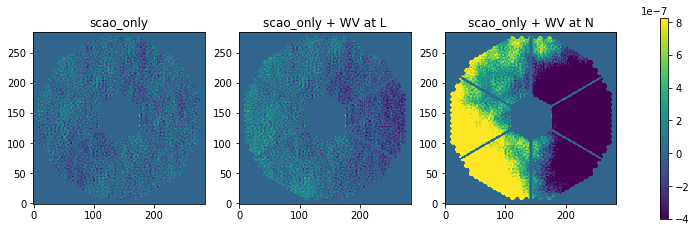

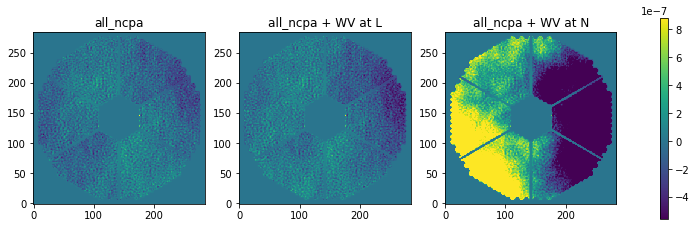

In [6]:
i = 20 # frame number
for case in ['scao_only', 'all_ncpa']:
    wv_out = os.path.join(dir_current, 'water_vapor', (filename%(date, duration, samp_scao, npupil))[:-5] \
            + '_WV%s.fits').replace('scao_only', case)
    if not os.path.isfile(wv_out%'N'):
        print('writeto %s'%wv_out)
        cube = resize_cube(fits.getdata(wv)[::step], npupil)
        fits.writeto(wv_out%'L', np.float32(fits.getdata(scao.replace('scao_only', case)) \
                                            + cube*(rms_L/temporal_rms)), overwrite=True)
        fits.writeto(wv_out%'N', np.float32(fits.getdata(scao.replace('scao_only', case)) \
                                            + cube*(rms_N/temporal_rms)), overwrite=True) 
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    plt.subplot(131); plt.title(case)
    im = plt.imshow(fits.getdata(scao.replace('scao_only', case))[i], origin=True)
    vmin, vmax = plt.gci().get_clim()
    plt.subplot(132); plt.title('%s + WV at L'%case)
    plt.imshow(fits.getdata(wv_out%'L')[i], origin=True, vmin=vmin, vmax=vmax)
    plt.subplot(133); plt.title('%s + WV at N'%case)
    plt.imshow(fits.getdata(wv_out%'N')[i], origin=True, vmin=vmin, vmax=vmax)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax);

### Zernike fitting

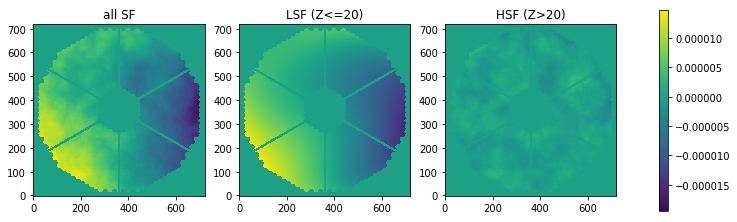

In [7]:
i = 20*step # frame number
spsd_name = wv[:-5] + '_%s' + '_%s.fits'%nzer_psd
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
plt.subplot(131); im = plt.imshow(fits.getdata(wv)[i], origin=True); plt.title('all SF')
vmin, vmax = plt.gci().get_clim()
plt.subplot(132); plt.title('LSF (Z<=%s)'%nzer_psd)
plt.imshow(fits.getdata(spsd_name%'LSFs')[-1,i], origin=True, vmin=vmin, vmax=vmax)
plt.subplot(133); plt.title('HSF (Z>%s)'%nzer_psd)
plt.imshow(fits.getdata(spsd_name%'HSFs')[-1,i], origin=True, vmin=vmin, vmax=vmax)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax);

### Temporal PSD

getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/cube_Cbasic_20201130_3600s_300ms_0piston_meters_scao_only_285_zpols_100.fits
getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100.fits


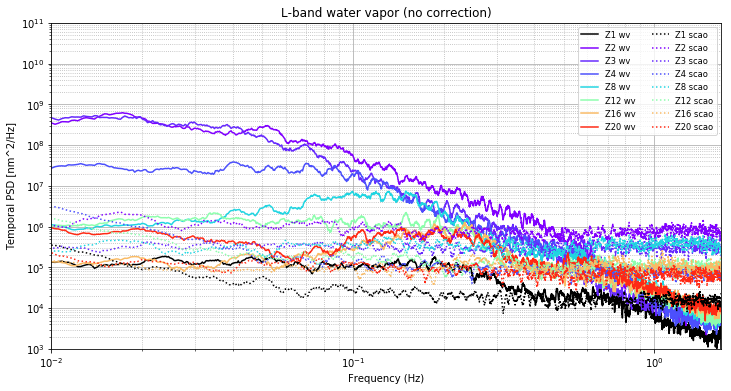

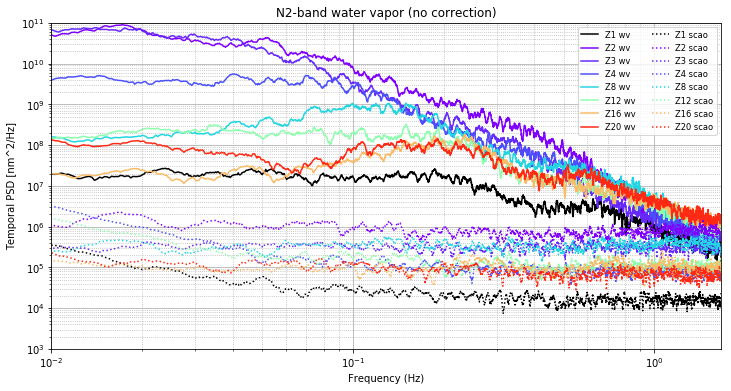

In [8]:
tpsd_scao = psd_temporal(get_zernike(scao, pup, nzer)[:,:nzer_psd])*1e9**2
tpsd_wv = psd_temporal(get_zernike(wv, pup, nzer)[::step,:nzer_psd])*1e9**2
tpsd_wvl = tpsd_wv*(rms_L/temporal_rms)**2
tpsd_wvn = tpsd_wv*(rms_N/temporal_rms)**2
plot_tpsd(tpsd_wvl, 'wv', tpsd_scao, 'scao', 'L-band water vapor (no correction)')
plot_tpsd(tpsd_wvn, 'wv', tpsd_scao, 'scao', 'N2-band water vapor (no correction)')

# 2/ Rolling average correction

In [9]:
freqs = [(1,1), (1,10), (1,100)]
for nLF, nHF in freqs:
    get_zpols_roll(zpols, nLF, nHF)

getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_1.fits
getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_10.fits
getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_100.fits


### Temporal PSD

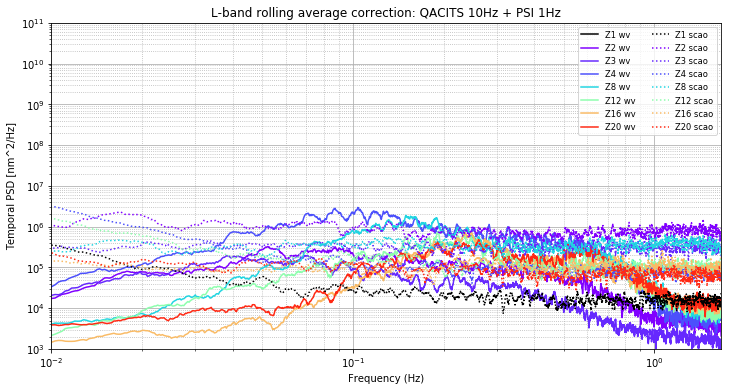

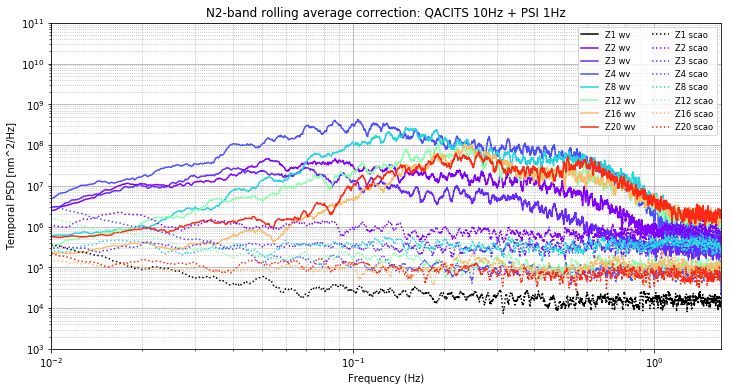

In [10]:
zpols_roll_1 = fits.getdata(wv[:-5] + '_zpols_100_nLF_1_nHF_1.fits')
zpols_roll_10 = fits.getdata(wv[:-5] + '_zpols_100_nLF_1_nHF_10.fits')
zpols_roll_100 = fits.getdata(wv[:-5] + '_zpols_100_nLF_1_nHF_100.fits')
tpsd_wv = psd_temporal((zpols - zpols_roll_10)[::step,:nzer_psd])*1e9**2
tpsd_wvl = tpsd_wv*(rms_L/temporal_rms)**2
tpsd_wvn = tpsd_wv*(rms_N/temporal_rms)**2
plot_tpsd(tpsd_wvl, 'wv', tpsd_scao, 'scao', 'L-band rolling average correction: QACITS 10Hz + PSI 1Hz')
plot_tpsd(tpsd_wvn, 'wv', tpsd_scao, 'scao', 'N2-band rolling average correction: QACITS 10Hz + PSI 1Hz')

### WFE for Zernikes 4-100

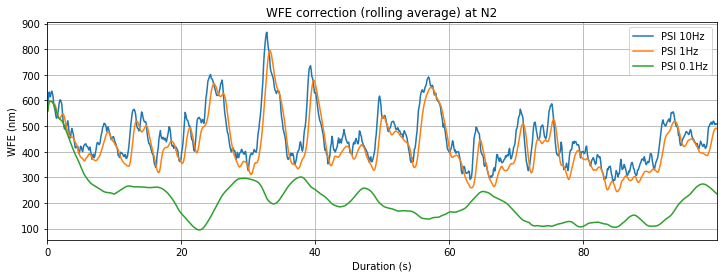

In [11]:
scaling = rms_N/temporal_rms*1e9
nframes = 1000
Z = zpols[:nframes]
ts = np.arange(len(Z))*samp_wv/1e3
m = range(3,nzer)
plt.figure(figsize=(12,4))
plt.plot(ts, np.sqrt(np.sum(zpols_roll_1[:nframes,m]**2,1))*scaling, label='PSI 10Hz')
plt.plot(ts, np.sqrt(np.sum(zpols_roll_10[:nframes,m]**2,1))*scaling, label='PSI 1Hz')
plt.plot(ts, np.sqrt(np.sum(zpols_roll_100[:nframes,m]**2,1))*scaling, label='PSI 0.1Hz')
plt.legend(); plt.grid('on')
plt.title('WFE correction (rolling average) at N2')
plt.xlabel('Duration (s)')
plt.ylabel('WFE (nm)')
plt.xlim((0, ts[-1]));

# 3/ Closed-loop control with an integrator

In [12]:
for G in [.2, .4, .6, .8, 1]:
    get_zpols_integ(zpols, 1, 10, G)

getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_10_G_0.2.fits
getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_10_G_0.4.fits
getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_10_G_0.6.fits
getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_10_G_0.8.fits
getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100_nLF_1_nHF_10_G_1.fits


### Temporal PSD

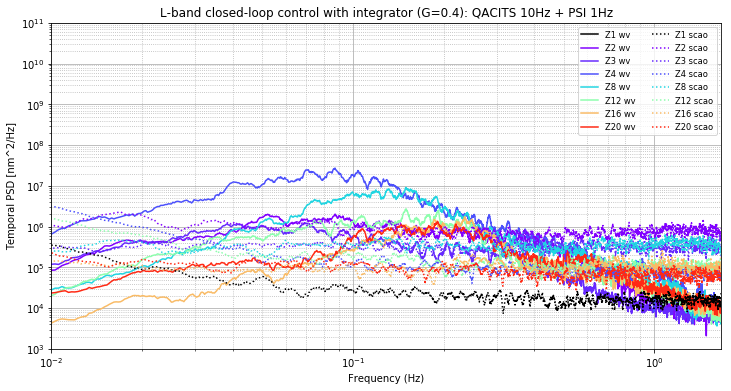

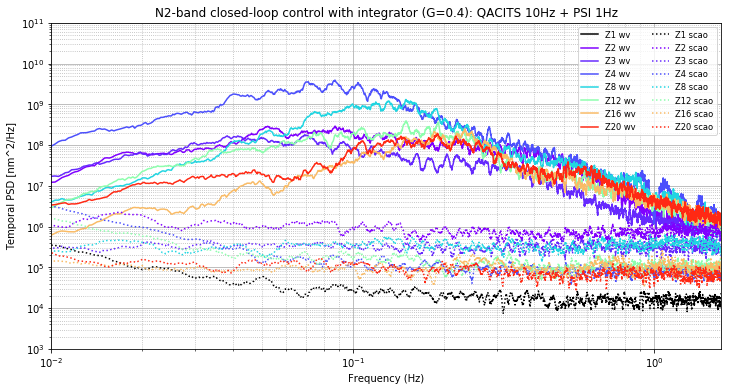

In [13]:
zpols_integ_04 = fits.getdata(wv[:-5] + '_zpols_100_nLF_1_nHF_10_G_0.4.fits')
tpsd_wv = psd_temporal((zpols - zpols_integ_04)[::step,:nzer_psd])*1e9**2
tpsd_wvl = tpsd_wv*(rms_L/temporal_rms)**2
tpsd_wvn = tpsd_wv*(rms_N/temporal_rms)**2
plot_tpsd(tpsd_wvl, 'wv', tpsd_scao, 'scao', 'L-band closed-loop control with integrator (G=0.4): QACITS 10Hz + PSI 1Hz')
plot_tpsd(tpsd_wvn, 'wv', tpsd_scao, 'scao', 'N2-band closed-loop control with integrator (G=0.4): QACITS 10Hz + PSI 1Hz')

### Tip-tilt at 10 Hz

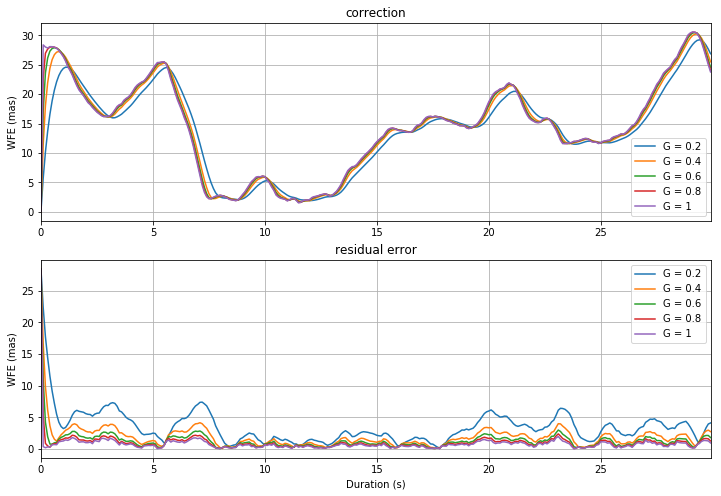

In [14]:
nmrms2mas = 4/36.905e9*u.rad.to('mas')
scaling = rms_N/temporal_rms*1e9
nframes = 300
plot_integ(nframes, range(1,3), scaling*nmrms2mas, yunits='mas', nLF=1, nHF=1)

### Tip-tilt at 3.33 Hz

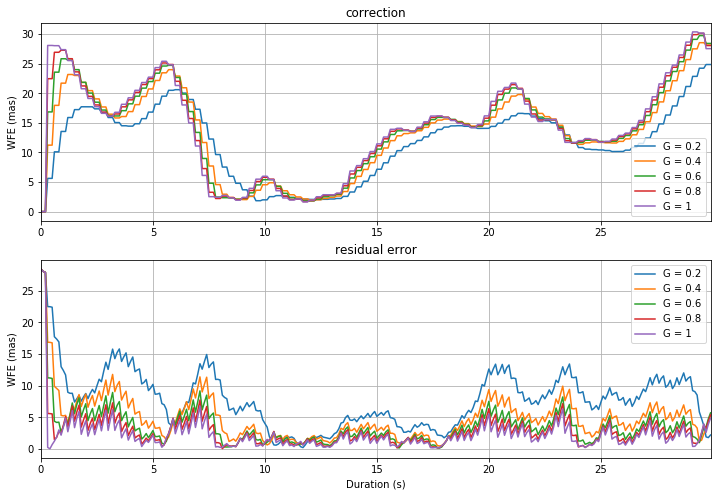

In [15]:
plot_integ(nframes, range(1,3), scaling*nmrms2mas, yunits='mas', nLF=3, nHF=3)

### Tip-tilt at 1 Hz

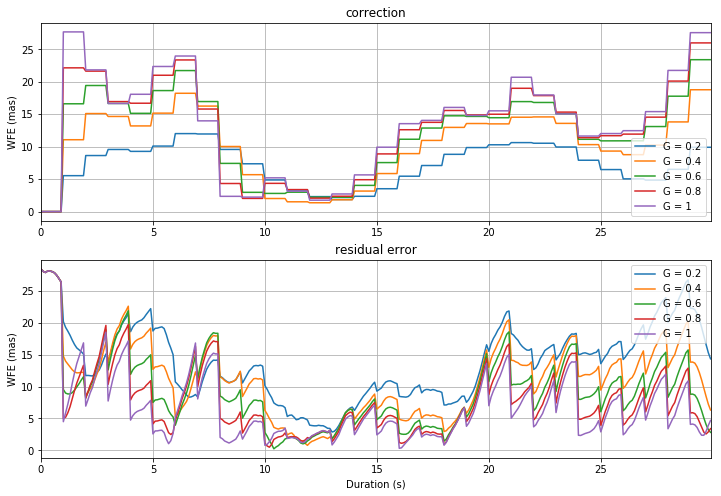

In [16]:
plot_integ(nframes, range(1,3), scaling*nmrms2mas, yunits='mas', nLF=10, nHF=10)

### Zernikes 4-100 at 10 Hz

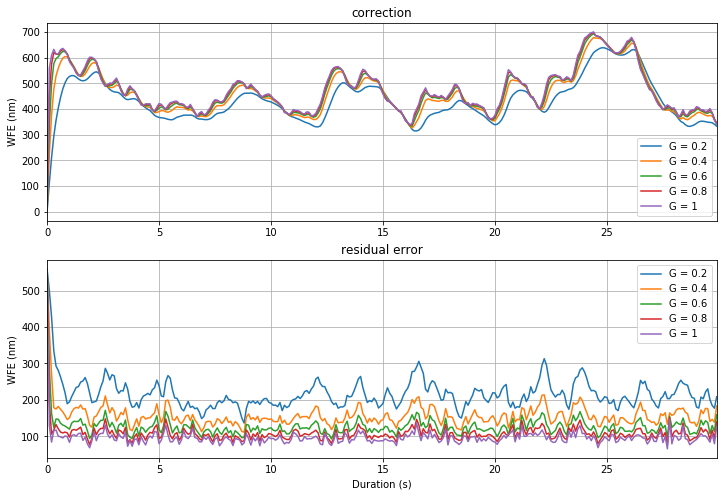

In [17]:
plot_integ(nframes, range(3,100), scaling, nLF=1, nHF=1)

### Zernikes 4-100 at 3.33 Hz

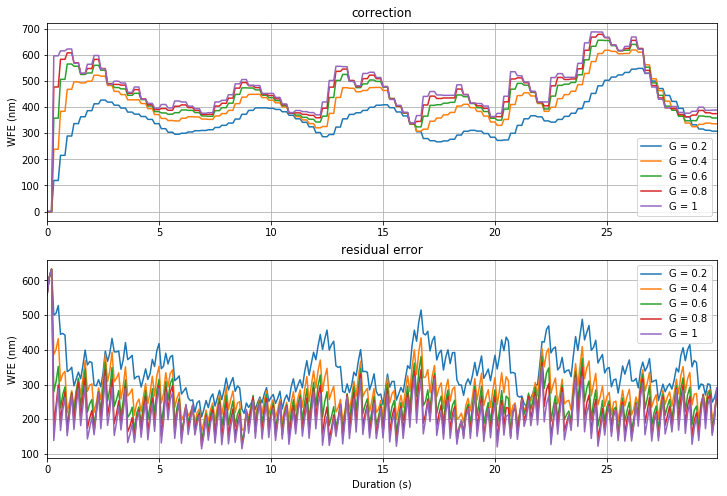

In [18]:
plot_integ(nframes, range(3,100), scaling, nLF=3, nHF=3)

### Zernikes 4-100 at 1 Hz

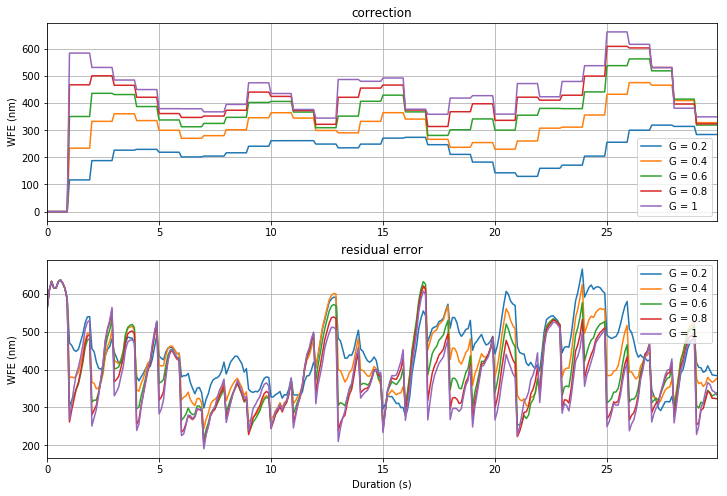

In [19]:
plot_integ(nframes, range(3,100), scaling, nLF=10, nHF=10)